# Improving robustness through Adversarial Training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/zangobot/teaching_material/blob/HEAD/03-AdversarialTraining.ipynb)

One possible way to counter the presence of adversarial examples is through **Adversarial Training**, that formalizes the training of a classifier as the following optimization problem:

$$
    \min_\boldsymbol{\theta} \max_{\boldsymbol{\delta}} \mathbb{E}_{(x, y)\sim D} [ L(\boldsymbol{x} + \boldsymbol{\delta}, y_i; \boldsymbol{\theta}) ]
  \\
  s.t.\quad ||\delta||_p \le \epsilon
  \\
  \text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

In words, the goal of adversarial training is finding a model that fits input data (the outer minimization), by taking into account the *worst* manipulation that can be applied to them (the inner maximisation) [1].
In practice, finding a solution to this problem is very hard, as the terms that are optimized have a direct impact on both the inner and the outer problem (and they can not be separated).

Hence, we can provide an *approximation* of this objective: we create an iterative approach that:
* fits a model on clean data;
* compute adversarial examples with a specific attack;
* combine clean and adversarial data (with correct label) and fit the classifier again;
* repeat the process.

We will start by looking at a simple 2D case first, and we will scale up to more difficult problems at the end of the notebook.

[1] Madry et al. "Towards deep learning models resistant to adversarial attacks", ICLR 2018, https://arxiv.org/pdf/1706.06083.pdf

In [1]:
try:
    import secml
except ImportError:
    %pip install git+https://github.com/pralab/secml

In [33]:
random_state = 999

n_features = 2  # number of features
n_samples = 1250  # number of samples
centers = [[-2, -2], [2, -2], [2, 2], [-2, 2]]  # centers of the clusters
cluster_std = 0.5  # standard deviation of the clusters
n_classes = len(centers)  # number of classes

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # number of training set samples
n_ts = 250  # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

In [63]:
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.peval.metrics import CMetricAccuracy


# creation of the multiclass classifier
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
clean_clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=random_state)

# fit the classifier
clean_clf.fit(tr.X, tr.Y)

# compute predictions on a test set
y_pred = clean_clf.predict(ts.X)

# Evaluate the accuracy of the classifier
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 100.00%


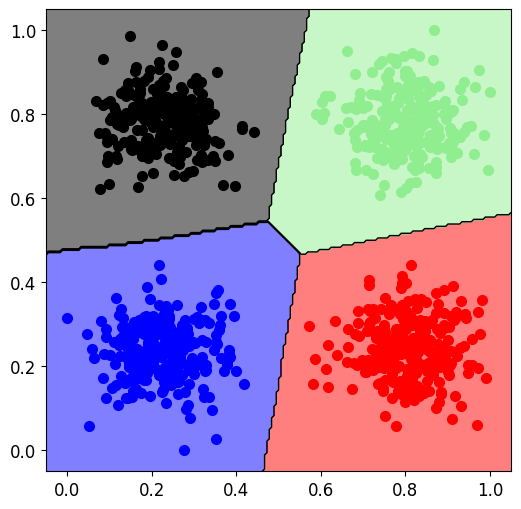

In [64]:
%matplotlib inline

# plot the samples and the decision function of the classifier
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.sp.plot_decision_regions(clean_clf, plot_background=True,
                             n_grid_points=200)
fig.show()

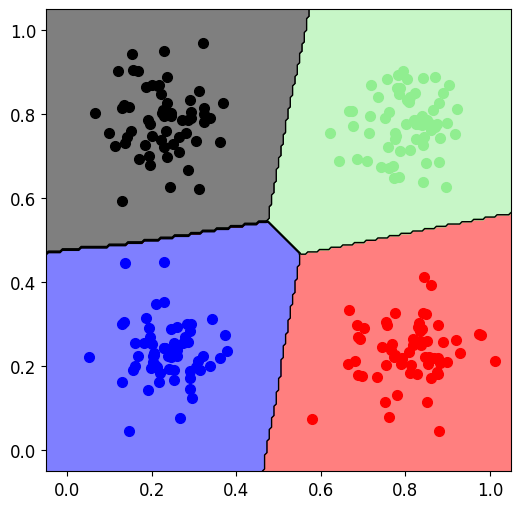

In [67]:
fig = CFigure()
fig.sp.plot_ds(ts)
fig.sp.plot_decision_regions(clean_clf, plot_background=True,
                             n_grid_points=200)
fig.show()

# Implementing a naive version of Adversarial Training

As said before, we need to create a loop that iteratively compute adversarial attacks against the classifier, and use them inside the next training of the classifier itself.

Adversarial training: iteration 0
(1200, 2) (1200,)


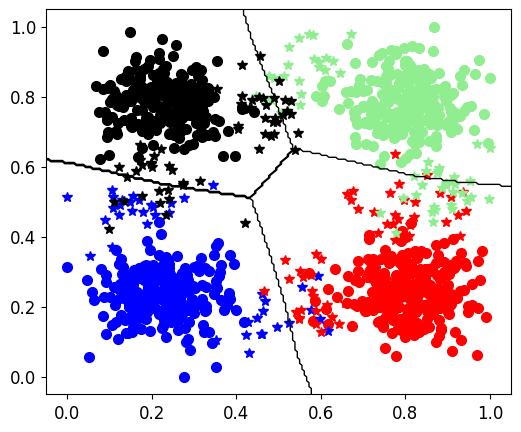

Adversarial training: iteration 1
(1400, 2) (1400,)


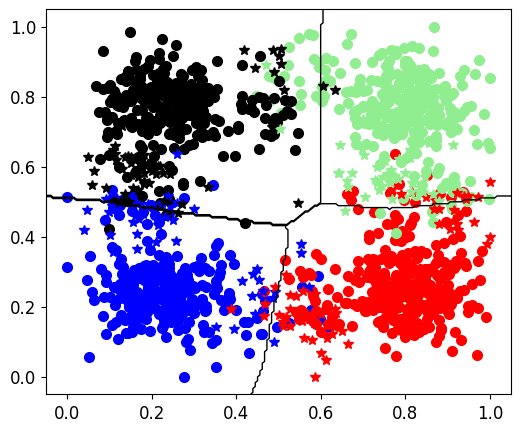

Adversarial training: iteration 2
(1600, 2) (1600,)


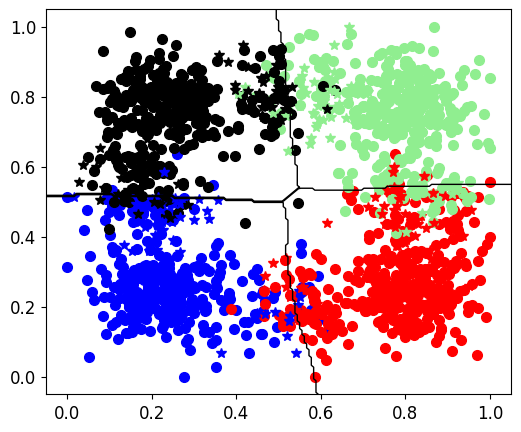

Adversarial training: iteration 3
(1800, 2) (1800,)


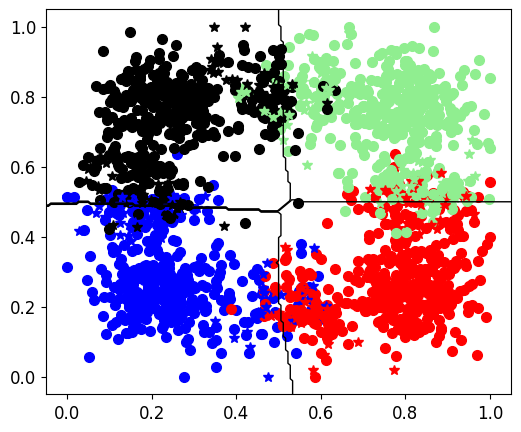

Adversarial training: iteration 4
(2000, 2) (2000,)


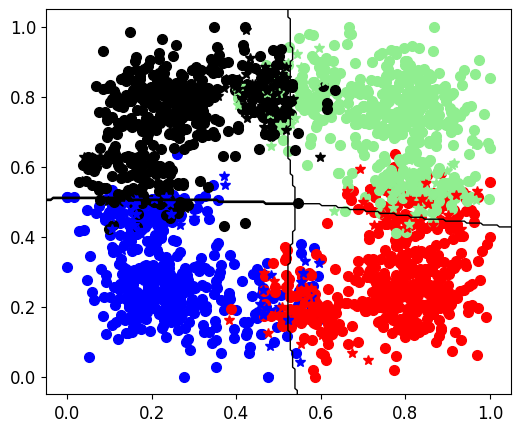

Adversarial training: iteration 5
(2200, 2) (2200,)


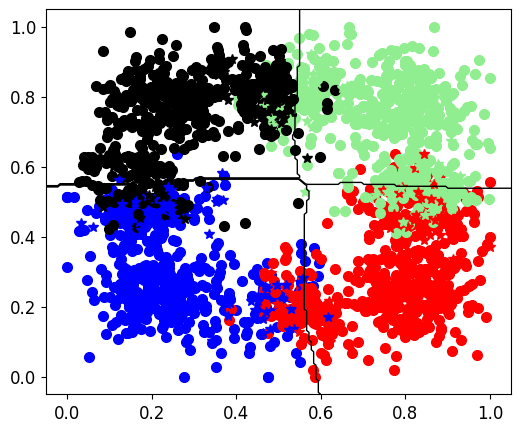

Adversarial training: iteration 6
(2400, 2) (2400,)


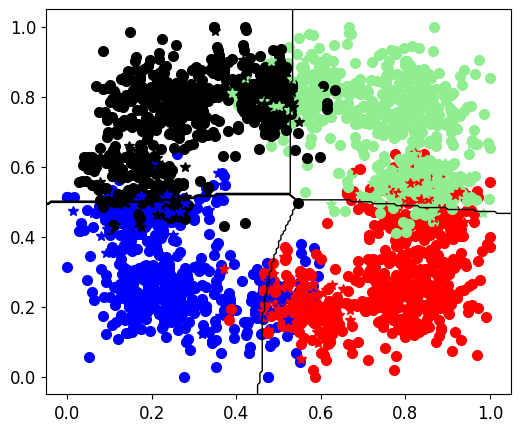

Adversarial training: iteration 7
(2600, 2) (2600,)


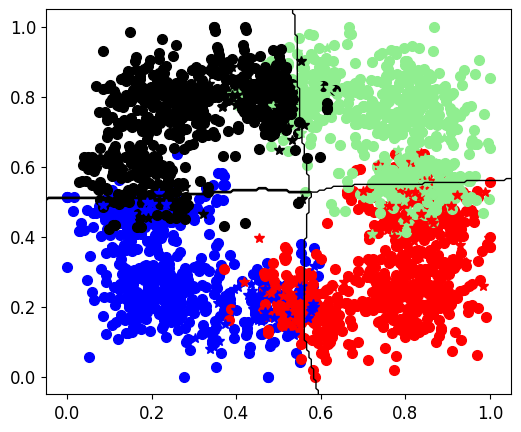

Adversarial training: iteration 8
(2800, 2) (2800,)


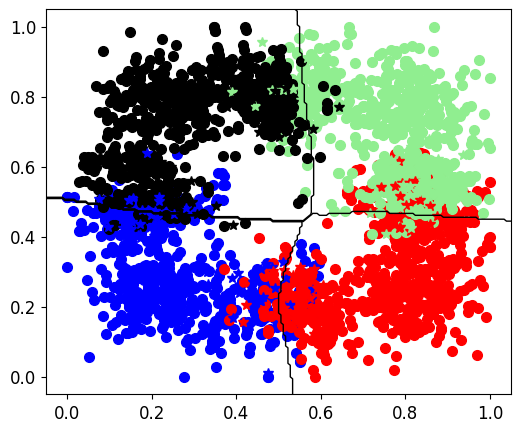

Adversarial training: iteration 9
(3000, 2) (3000,)


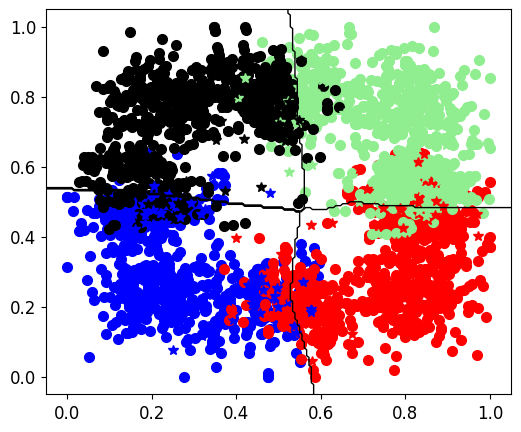

In [78]:
%matplotlib inline
from secml.data import CDataset
import sklearn
from secml.adv.attacks import CFoolboxPGDL2

n_retrains = 10
how_many_adv = 200
y_target = None
lb, ub = 0, 1
eps = 0.2
alpha = 0.05
steps = 10
advtr_dataset = CDataset(tr.X, tr.Y) # we copy the clean classifier for later
at_clf = clean_clf.deepcopy()
pgd_attack = CFoolboxPGDL2(at_clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha,
                           steps=steps,
                           random_start=False)

for i in range(n_retrains):
    print(f'Adversarial training: iteration {i}')
    indeces = sklearn.utils.random.sample_without_replacement(n_population=tr.X.shape[0], n_samples=how_many_adv, random_state=random_state).tolist()
    trY = tr.Y[indeces]
    y_pred, _, adv_ds_pgd, _ = pgd_attack.run(tr.X[indeces,:], trY)
    fig = CFigure(height=5, width=6)
    fig.sp.plot_ds(advtr_dataset, markers='o')
    fig.sp.plot_ds(CDataset(adv_ds_pgd.X, trY), markers='*')
    advtr_dataset = advtr_dataset.append(CDataset(adv_ds_pgd.X, trY)) # we include the computed adversarial examples inside the training set
    at_clf.fit(advtr_dataset.X, advtr_dataset.Y) # we fit the classifier with all the points
    fig.sp.plot_decision_regions(at_clf, plot_background=False, n_grid_points=200) # this plot will show how the boundary changes over each iteration of the adversarial training
    fig.show()

After the completion of the adversarial training, we can compute the difference in robustness achieved.

In [80]:
ys_pred_y = clean_clf.predict(ts.X)
clean_accuracy = CMetricAccuracy().performance_score(ts.Y, ys_pred_y)
print('Clean accuracy of regular model: ', clean_accuracy)

ys_pred_y = at_clf.predict(ts.X)
clean_accuracy = CMetricAccuracy().performance_score(ts.Y, ys_pred_y)
print('Clean accuracy of AT model: ', clean_accuracy)

n_samples = 100
steps_2 = 10
pgd_attack_at = CFoolboxPGDL2(at_clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha,
                           steps=steps_2,
                           random_start=False)
at_adv_y_pred, _, _, _ = pgd_attack_at.run(ts.X[:n_samples, :], ts.Y[:n_samples])
at_robust_accuracy = CMetricAccuracy().performance_score(ts.Y[:n_samples], at_adv_y_pred)
print('Robust Accuracy of AT model:', at_robust_accuracy)

pgd_attack_clean = CFoolboxPGDL2(clean_clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha,
                           steps=steps_2,
                           random_start=False)
adv_y_pred, _, _, _ = pgd_attack_clean.run(ts.X[:n_samples, :], ts.Y[:n_samples])
robust_accuracy = CMetricAccuracy().performance_score(ts.Y[:n_samples], adv_y_pred)
print('Robust Accuracy of regular model:', robust_accuracy)

Clean accuracy of regular model:  1.0
Clean accuracy of AT model:  1.0
Robust Accuracy of AT model: 0.73
Robust Accuracy of regular model: 0.69


The improvement is not so much, right? This is a toy 2D problem, and we are using a very simple network, hence it is difficult to find a solution that separates the four classes.

# RobustBench: a benchmark for Adversarial Robustness

Computing adversarial training on 2D problems is easy, but repeating the same loop for models trained on more complex problems (such as MNIST classification), the overall process becomes more and more complicated.
